# Simple Recurrent Network (SRN, Elman 1990) applied to sMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
State update:

$
\vec{h}_t = \tanh(W_{hx}\vec{x}_t + W_{hh}\vec{h}_{t-1} + \vec{b}_h) \text{ with }\vec{h}_t \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x}
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [4]:
DATASET_VERSION = 'sequential'
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [6]:
from typing import Sequence

class RNNLayer(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):

        def update(self, h, x):
            x = jnp.concatenate([h, x])
            h_new = jnp.tanh(nn.Dense(h.shape[0], name='Dense_RNN')(x))
            return h_new, h_new

        scan_update = nn.scan(
            update,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        h = jnp.zeros((self.hidden_size,))
        _, state_hist = scan_update(self, h, x)

        return state_hist

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    num_layers: int

    @nn.compact
    def __call__(self, x):
        state_hist = []
        for _ in range(self.num_layers-1):
            x = RNNLayer(self.hidden_size, self.output_size)(x)
            state_hist.append(x)
        x = RNNLayer(self.hidden_size, self.output_size)(x)
        state_hist.append(x)
        out = nn.Dense(self.output_size, name='Dense_Out')(x)
        return state_hist, out
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [7]:
model = BatchRNN(256, 10, 1)
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
state_hist, out_hist = model.apply(params, batch_x[:5])
print(len(state_hist), state_hist[0].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

1 (5, 784, 256) (5, 784, 10)
(5, 10)
[[-0.103  0.135  0.113 -0.115  0.161  0.103 -0.096  0.165  0.012  0.246]
 [-0.09   0.117  0.099 -0.1    0.141  0.091 -0.084  0.143  0.011  0.214]
 [-0.115  0.151  0.123 -0.128  0.18   0.113 -0.107  0.186  0.014  0.276]
 [-0.08   0.104  0.086 -0.088  0.125  0.079 -0.074  0.128  0.01   0.192]
 [-0.103  0.135  0.109 -0.114  0.161  0.101 -0.095  0.165  0.012  0.247]]


In [8]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[2.207 2.263 2.23  2.436 2.211]
2.269288


In [9]:
print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))


params: 
 {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}


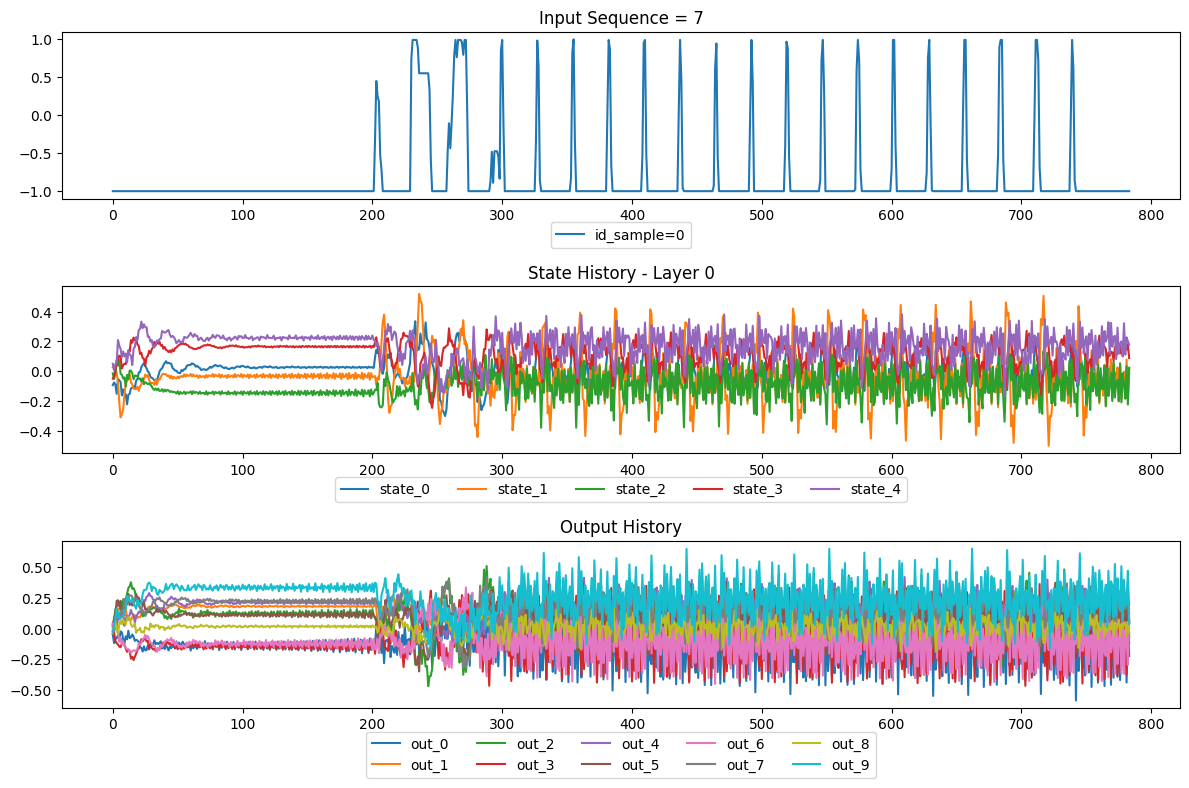

In [10]:
plot_dynamics(model, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=0)

In [11]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [12]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [28]:
@jax.jit
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [29]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [30]:
def create_train_state(key, model_cls, lr, dataset_version, hidden_size=256, num_layers=1):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=hidden_size, output_size=10, num_layers=num_layers)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [31]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, 256, 1)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}


In [32]:
for epoch in range(2):
    key, subkey = jax.random.split(key)
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training: 100%|██████████| 468/468 [00:18<00:00, 25.21it/s, accuracy=0.0859, loss=2.3] 


Epoch 0 | Loss: 2.2912023067474365 | Accuracy: 0.12393162399530411


Training: 100%|██████████| 468/468 [00:18<00:00, 25.85it/s, accuracy=0.18, loss=2.28]  

Epoch 1 | Loss: 2.282238483428955 | Accuracy: 0.1280215084552765


In [33]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}
{'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}


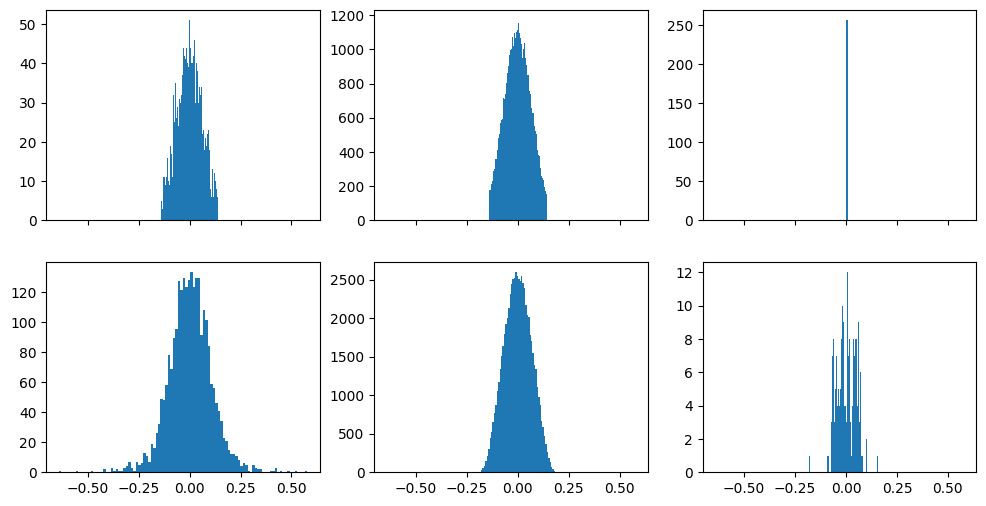

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(1200*px, 600*px), sharex=True)
axs[0,0].hist(params['params']['Dense_Out']['kernel'].flatten(), bins=100)
axs[0,1].hist(params['params']['RNNLayer_0']['Dense_RNN']['kernel'].flatten(), bins=100)
axs[0,2].hist(params['params']['RNNLayer_0']['Dense_RNN']['bias'].flatten(), bins=100)
axs[1,0].hist(state.params['Dense_Out']['kernel'].flatten(), bins=100)
axs[1,1].hist(state.params['RNNLayer_0']['Dense_RNN']['kernel'].flatten(), bins=100)
axs[1,2].hist(state.params['RNNLayer_0']['Dense_RNN']['bias'].flatten(), bins=100)
plt.show()

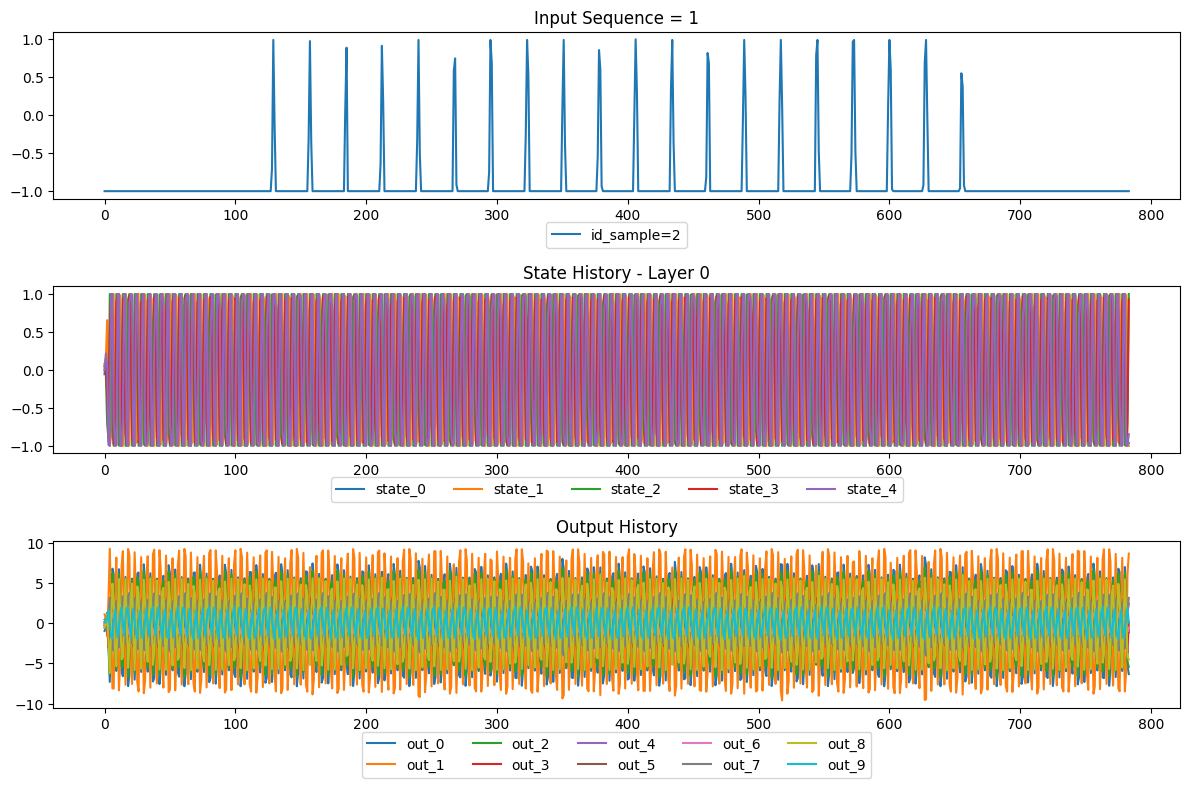

In [35]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)

In [36]:
all_state_hist, out_hist = model.apply({'params':state.params}, batch_x[:5])
print(len(all_state_hist), all_state_hist[0].shape, out_hist.shape) # (batch, time, cell_size)

1 (5, 784, 256) (5, 784, 10)


In [37]:
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

(5, 10)
[[-0.103  0.132 -0.049 -0.003 -0.009 -0.078 -0.025  0.042 -0.061  0.014]
 [-0.02   0.04  -0.004  0.023 -0.026 -0.076 -0.013  0.007 -0.018  0.005]
 [-0.176  0.21  -0.087 -0.026  0.007 -0.081 -0.036  0.072 -0.097  0.022]
 [ 0.048 -0.034  0.032  0.044 -0.04  -0.074 -0.002 -0.021  0.017 -0.002]
 [-0.096  0.123 -0.044 -0.001 -0.01  -0.078 -0.024  0.039 -0.057  0.013]]


In [38]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5,)
[2.249 2.299 2.078 2.252 2.301]
2.2358568


# Multi Layer (3 hidden, 1 output) Simple Recurrent Network (SRN, Elman 1990) applied to sMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
State update:

$
\vec{h}_t^1 = \tanh(W_{hx}^1\vec{x}_t + W_{hh}^1\vec{h}_{t-1}^1 + \vec{b}_h^1) \text{ with }\vec{h}_t^1 \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x} \\
\vec{h}_t^2 = \tanh(W_{hx}^2\vec{h}_t^1 + W_{hh}^2\vec{h}_{t-1}^2 + \vec{b}_h^2) \text{ with }\vec{h}_t^2 \in \mathbb{R}^{n_h} \\
\vec{h}_t^3 = \tanh(W_{hx}^3\vec{h}_t^2 + W_{hh}^3\vec{h}_{t-1}^2 + \vec{b}_h^3) \text{ with }\vec{h}_t^3 \in \mathbb{R}^{n_h} \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t^3 + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [39]:
DATASET_VERSION = 'sequential'
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [40]:
model = BatchRNN(256, 10, 3)
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, 256, 3)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}, 'RNNLayer_1': {'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}, 'RNNLayer_2': {'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}


In [41]:
for epoch in range(2):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training: 100%|██████████| 468/468 [00:49<00:00,  9.55it/s, accuracy=0.125, loss=2.29] 


Epoch 0 | Loss: 2.304612398147583 | Accuracy: 0.11965811997652054


Training: 100%|██████████| 468/468 [00:48<00:00,  9.66it/s, accuracy=0.133, loss=2.3]  

Epoch 1 | Loss: 2.2971558570861816 | Accuracy: 0.11733774095773697


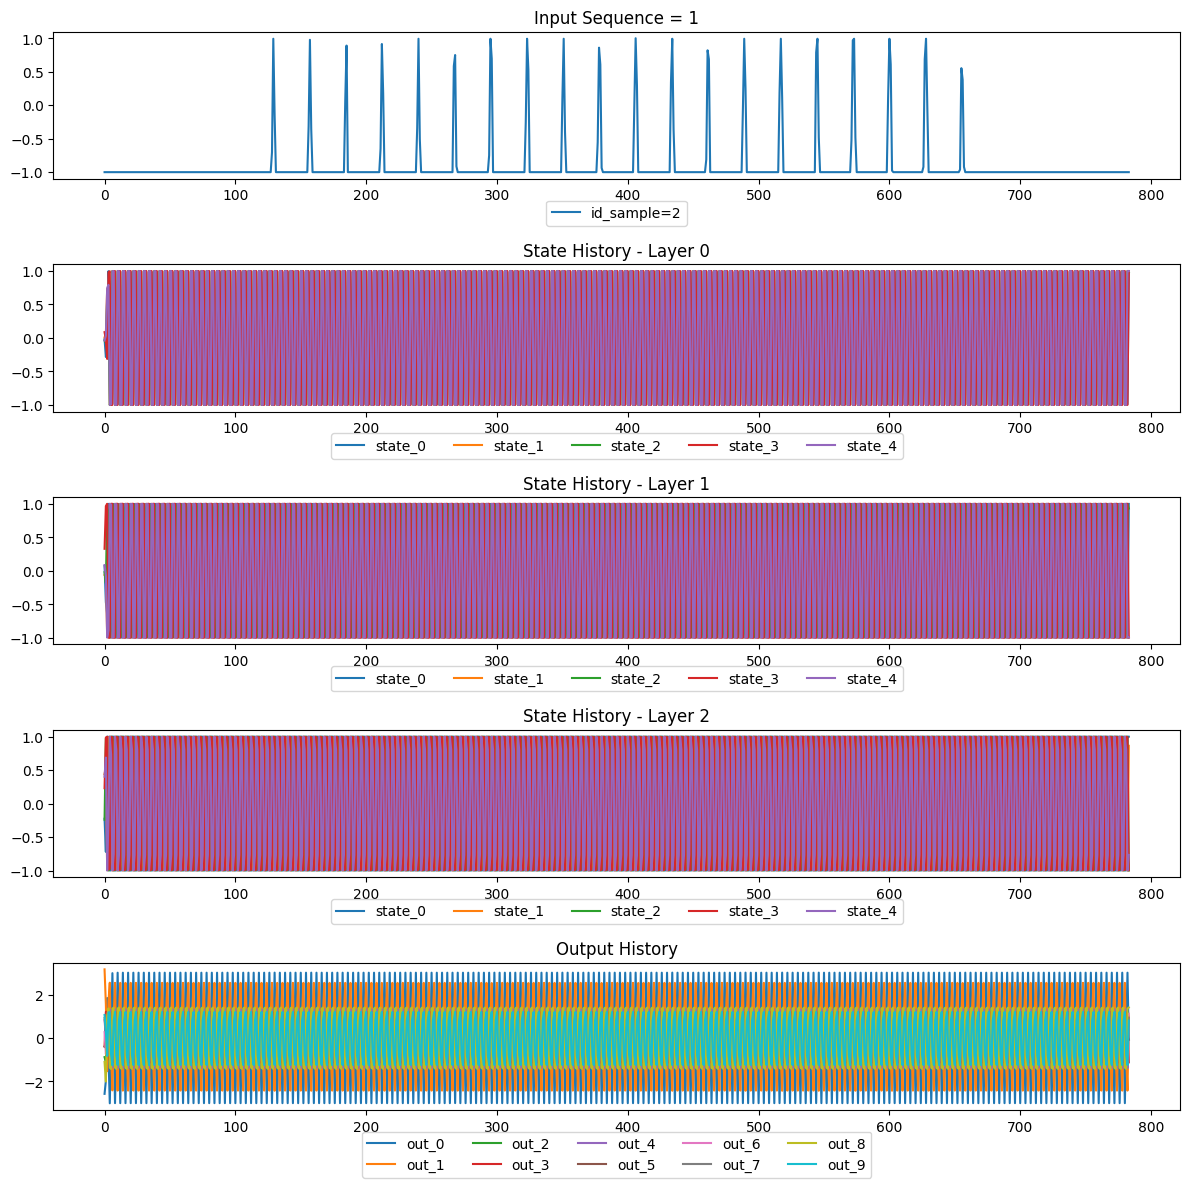

In [42]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)